<a href="https://colab.research.google.com/github/AgufSamudra/Time-Series-Project/blob/main/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Import the Dataset

Frist we have import the dataset, and dataset we will use the name is a datatraining.txt.

also we add **delimiter** because our data has a comma seperator.


In [2]:
df = pd.read_csv('datatraining.txt', delimiter=',', quoting = 3)
df.head()

,"""date""","""Temperature""","""Humidity""","""Light""","""CO2""","""HumidityRatio""","""Occupancy"""
"""1""","""2015-02-04 17:51:00""",23.18,27.2720,426.0,721.25,0.004793,1
"""2""","""2015-02-04 17:51:59""",23.15,27.2675,429.5,714.00,0.004783,1
"""3""","""2015-02-04 17:53:00""",23.15,27.2450,426.0,713.50,0.004779,1
"""4""","""2015-02-04 17:54:00""",23.15,27.2000,426.0,708.25,0.004772,1
"""5""","""2015-02-04 17:55:00""",23.10,27.2000,426.0,704.50,0.004757,1


And then we have to check the data, does the data have data loss.

with fungtion **isnull().sum()** we can see the missing data from our data. But our data is not lost, so we don't need to fill in the missing data.

In [3]:
df.isnull().sum()

"date"             0
"Temperature"      0
"Humidity"         0
"Light"            0
"CO2"              0
"HumidityRatio"    0
"Occupancy"        0
dtype: int64

Also we will check the data with **info()**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, "1" to "8143"
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   "date"           8143 non-null   object 
 1   "Temperature"    8143 non-null   float64
 2   "Humidity"       8143 non-null   float64
 3   "Light"          8143 non-null   float64
 4   "CO2"            8143 non-null   float64
 5   "HumidityRatio"  8143 non-null   float64
 6   "Occupancy"      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


# Split the data to Training Set and Test Set

Because what we need is the date and Temperature column, so we only take that column. We can leave the rest.

And look at the visuals of the dataset.

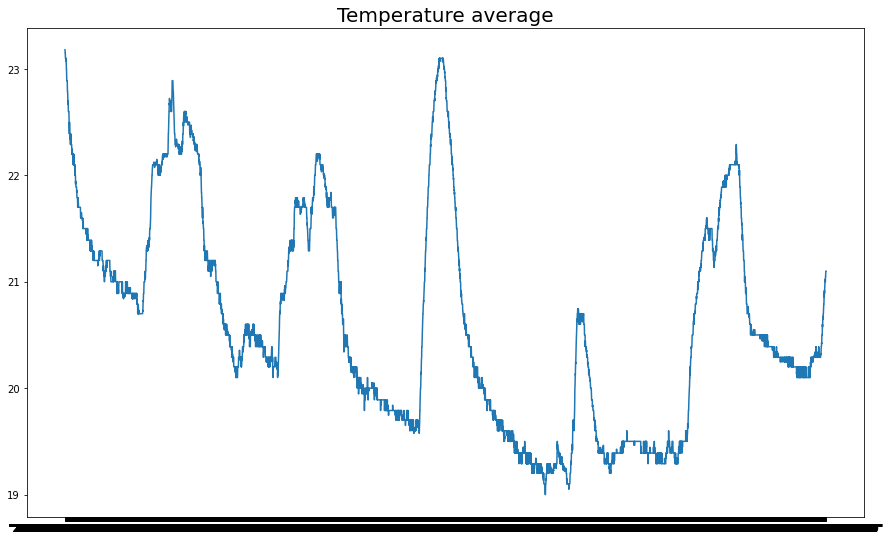

In [5]:
X = df.iloc[:, 0].values
y = df.iloc[:, 1].values

plt.figure(figsize=(15,9))
plt.plot(X, y)
plt.title('Temperature average',
          fontsize=20);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

###Then we create a function to receive a series/attribute that we have converted to numpy type, then return the labels and attributes of the dataset in batch form.

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Make a Architecture

Also we will create the architecture for our Time Series model.

In [7]:
train_set = windowed_dataset(y_train, window_size=32, batch_size=50, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=32, batch_size=50, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

# Make a Callback Class

Since we will be aiming for the MAE of the model < 10% of the data scale, we will see what score we want to achieve.

In [8]:
Mae = (df['"Temperature"'].max() - df['"Temperature"'].min()) * 10/100
print(Mae)

0.418


We create a Callback Class

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.4 and logs.get('val_mae')<0.4):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

### Optimizer and Train the Dataset



In [11]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data = val_set,callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


130/130 [==============================] - 22s 98ms/step - loss: 0.2501 - mae: 0.5838 - val_loss: 0.0481 - val_mae: 0.3011
Epoch 2/100
130/130 [==============================] - 7s 53ms/step - loss: 0.2417 - mae: 0.5729 - val_loss: 0.0945 - val_mae: 0.4275
Epoch 3/100
130/130 [==============================] - 7s 54ms/step - loss: 0.2382 - mae: 0.5671 - val_loss: 0.1111 - val_mae: 0.4647
Epoch 4/100
130/130 [==============================] - 7s 53ms/step - loss: 0.2383 - mae: 0.5681 - val_loss: 0.0312 - val_mae: 0.2371
Epoch 5/100
130/130 [==============================] - 7s 56ms/step - loss: 0.2449 - mae: 0.5742 - val_loss: 0.1187 - val_mae: 0.4815
Epoch 6/100
130/130 [==============================] - 7s 54ms/step - loss: 0.2338 - mae: 0.5616 - val_loss: 0.0548 - val_mae: 0.3227
Epoch 7/100
130/130 [==============================] - 7s 55ms/step - loss: 0.2227 - mae: 0.5458 - val_loss: 0.0233 - val_mae: 0.2041
Epoch 8/100
130/130 [==============================] - 7s 52ms/step - los

### Visual the Result

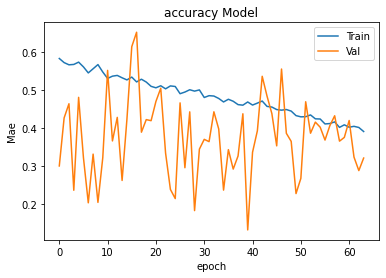

In [12]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('accuracy Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

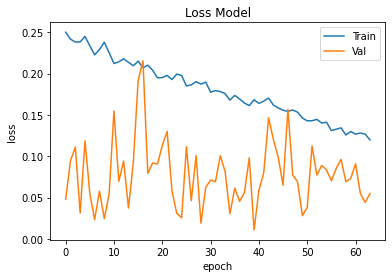

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()